# Dynamic Mode Decomposition benchmark
A very basic benchmark to understand how to tune DMD Deep Learning pipelines for the best performance.

In [1]:
import time

from data import data_maker_fluid_flow_full

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)

import torch
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np

from pydmd import DMD

In [2]:
repeats = 10
mininbatch_size = [256, 512, 1024, 2048, 5096, 10192]

### Experiments
| Backend | Processor | Tensorized         |
|---------|:-----------:|:--------------------:|
| NumPy   | CPU       | &#x274C;	                |
| PyTorch | CPU       | &#x274C;	                |
| PyTorch | GPU       | &#x274C;	                |
| PyTorch | CPU       | &#x2705;	 |
| PyTorch | GPU       | &#x2705;	 |

### DMD variant
We consider the standard DMD variant from `Kutz, J. Nathan, et al. Dynamic mode decomposition: data-driven modeling of complex systems. Society for Industrial and Applied Mathematics, 2016.`

### Hardware
- Host: `agnesi.maths.sissa.it`
- CPU: `11th Gen Intel(R) Core(TM) i7-11700 @ 2.50GHz`
- GPU: `NVIDIA Quadro RTX 4000`

### Software
- NumPy: `1.22.0`
- PyTorch: `1.13.1`
- CUDA: `cuda/11.7`

## Experiment 1: *fitting*
In the first experiment we measure the performance of fitting a batch of DMDs (i.e. `dmd.fit`). We generate a set of `batch_size` systems with random initial conditions, with dimension `3x601`. Then we try to fit `batch_size` DMDs with different methods and architectures, and we measure the time it takes to do so.

In [ ]:
def run(X, batch):
    m = 100000000000000
    if batch:
        # GLAPPO
        for repeat in range(repeats):
            start = time.time_ns()
            dmd = DMD(svd_rank=-1)
            dmd.fit(data)
            elapsed = time.time_ns() - start
            m = min(m, elapsed)
    else:
        # Legacy PyDMD
        for repeat in range(repeats):
            start = time.time_ns()
            dmd = DMD(svd_rank=-1)
            for instance in data:
                dmd.fit(instance)
            elapsed = time.time_ns() - start
            m = min(m, elapsed)
    return m

In [ ]:
nontensorized_cpu_numpy = []
nontensorized_cpu = []
nontensorized_gpu = []
tensorized_cpu = []
tensorized_gpu = []

for size in mininbatch_size:
    print(f'---- {size} ----')
    data = data_maker_fluid_flow_full(
        x1_lower=-1.1,
        x1_upper=1.1,
        x2_lower=-1.1,
        x2_upper=1.1,
        x3_lower=0.0,
        x3_upper=2,
        n_ic=size,
        dt=0.01,
        tf=6,
    ).swapaxes(-1, -2).astype(np.float32)
    print(data.shape, data.dtype)
    
    m = run(data, False)
    nontensorized_cpu_numpy.append(m / 1_000_000)
    print('nonbatch-cpu NumPy done')
    
    data = torch.from_numpy(data)
    
    m = run(data, False)
    nontensorized_cpu.append(m / 1_000_000)
    print('nonbatch-cpu done')
    
    m = run(data, True)
    tensorized_cpu.append(m / 1_000_000)
    print('batch-cpu done')
    
    data = data.cuda()
    print('moved to GPU')
    
    m = run(data, False)
    nontensorized_gpu.append(m / 1_000_000)
    print('nonbatch-gpu done')
    
    m = run(data, True)
    tensorized_gpu.append(m / 1_000_000)
    print('batch-gpu done')

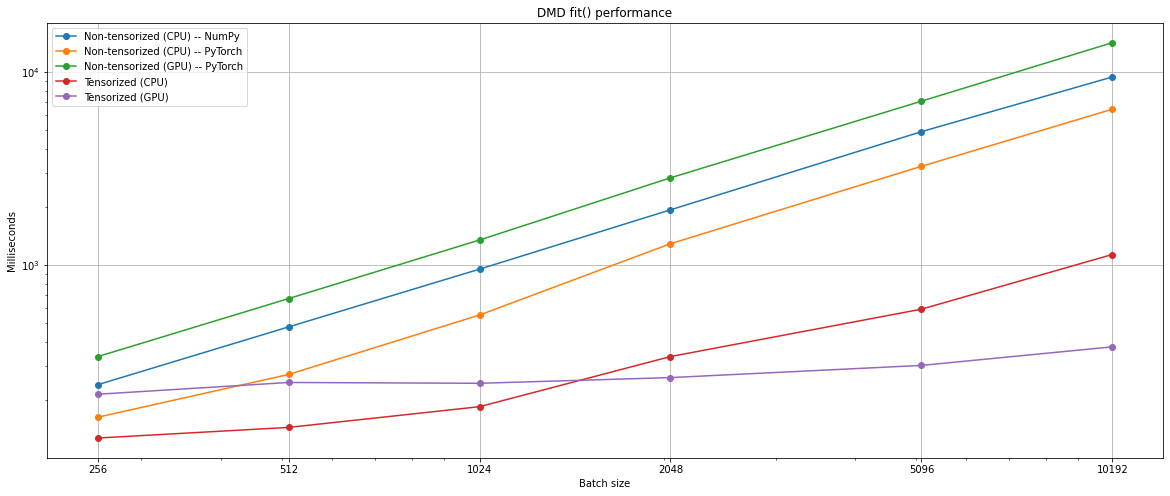

In [4]:
plt.figure(figsize=(20,8))

plt.title('DMD fit() performance')

plt.loglog(mininbatch_size, nontensorized_cpu_numpy, '-o', label='Non-tensorized (CPU) -- NumPy')
plt.loglog(mininbatch_size, nontensorized_cpu, '-o', label='Non-tensorized (CPU) -- PyTorch')
plt.loglog(mininbatch_size, nontensorized_gpu, '-o', label='Non-tensorized (GPU) -- PyTorch')
plt.loglog(mininbatch_size, tensorized_cpu, '-o', label='Tensorized (CPU)')
plt.loglog(mininbatch_size, tensorized_gpu, '-o', label='Tensorized (GPU)')

plt.xticks(mininbatch_size, mininbatch_size)
plt.xlabel('Batch size')
plt.ylabel('Milliseconds')

plt.grid()
plt.legend()

plt.show()

## Results interpretation
- Tensorized DMD is more performant by orders of magnitude wrt loop+DMD
- GPU boosts performance for large batch sizes, but it should not be used for non-tensorized training
- `GPU+tensorized` reacts much better to an increase in batch size (most likely due to how svd is implemented in PyTorch)

**Different space sizes might show different behaviors**.

## Profiling
We turn to PyTorch profiler to understand what's happening on GPU due to the (kind of) unsurprisingly bad performance.

In [10]:
data = data_maker_fluid_flow_full(
        x1_lower=-1.1,
        x1_upper=1.1,
        x2_lower=-1.1,
        x2_upper=1.1,
        x3_lower=0.0,
        x3_upper=2,
        n_ic=1024,
        dt=0.01,
        tf=6,
    )
data = torch.from_numpy(data).swapaxes(-1, -2)
data = data.to(dtype=torch.float32, device='cuda')

dmd = DMD(svd_rank=-1)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, with_stack=True) as prof:
    with record_function("model_inference"):
        dmd.fit(data)
        
with open("profiler.txt", "w") as f:
    f.write(prof.key_averages(group_by_stack_n=1).table(sort_by="cuda_time_total", row_limit=20))

STAGE:2023-02-12 09:55:33 1297138:1297138 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 10608860160.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
STAGE:2023-02-12 09:55:33 1297138:1297138 ActivityProfilerController.cpp:300] Completed Stage: Collection


The profiler clearly highlights that the culprits are `torch.linalg.svd` and `torch.linalg.cond`.

## Experiment 2: *reconstructing/predicting*
In this second experiment we measure the performance of `dmd.reconstructed_data` (i.e. reconstruction/prediction of the system after fitting). We try to predict 100 time instants further in time. The rest of the setting is the same as Experiment 1.

In [ ]:
def run(X, batch):
    m = 100000000000000
    if batch:
        # GLAPPO
        dmd = DMD(svd_rank=-1).fit(data)
        dmd.dmd_time['tend'] += 100
        for repeat in range(repeats):
            start = time.time_ns()
            dmd.reconstructed_data
            elapsed = time.time_ns() - start
            m = min(m, elapsed)
    else:
        # Legacy PyDMD
        for repeat in range(repeats):
            dmd = DMD(svd_rank=-1)
            t = 0
            for instance in data:
                dmd.fit(instance)
                dmd.dmd_time['tend'] += 100
                start = time.time_ns()
                dmd.reconstructed_data
                elapsed = time.time_ns() - start
                t += elapsed
            m = min(m, t)
    return m

In [5]:
nontensorized_cpu_numpy = []
nontensorized_cpu = []
nontensorized_gpu = []
tensorized_cpu = []
tensorized_gpu = []

for size in mininbatch_size:
    print(f'---- {size} ----')
    data = data_maker_fluid_flow_full(
        x1_lower=-1.1,
        x1_upper=1.1,
        x2_lower=-1.1,
        x2_upper=1.1,
        x3_lower=0.0,
        x3_upper=2,
        n_ic=size,
        dt=0.01,
        tf=6,
    ).swapaxes(-1, -2).astype(np.float32)
    print(data.shape, data.dtype)
    
    m = run(data, False)
    nontensorized_cpu_numpy.append(m / 1_000_000)
    print('nonbatch-cpu NumPy done')
    
    data = torch.from_numpy(data)
    
    m = run(data, False)
    nontensorized_cpu.append(m / 1_000_000)
    print('nonbatch-cpu done')
    
    m = run(data, True)
    tensorized_cpu.append(m / 1_000_000)
    print('batch-cpu done')
    
    data = data.cuda()
    print('moved to GPU')
    
    m = run(data, False)
    nontensorized_gpu.append(m / 1_000_000)
    print('nonbatch-gpu done')
    
    m = run(data, True)
    tensorized_gpu.append(m / 1_000_000)
    print('batch-gpu done')

---- 256 ----
(256, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 1935350400.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-cpu done
moved to GPU
nonbatch-gpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 40215527424.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-gpu done
---- 512 ----
(512, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 40107200512.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-cpu done
moved to GPU
nonbatch-gpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 166589218816.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-gpu done
---- 1024 ----
(1024, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 13372841984.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-cpu done
moved to GPU
nonbatch-gpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 44266930176.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-gpu done
---- 2048 ----
(2048, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 9348080640.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-cpu done
moved to GPU
nonbatch-gpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 35786166272.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-gpu done
---- 5096 ----
(5096, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 465577607168.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-cpu done
moved to GPU
nonbatch-gpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 8364277248.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-gpu done
---- 10192 ----
(10192, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 22578432000.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-cpu done
moved to GPU
nonbatch-gpu done


/u/f/fandreuz/miniconda3/lib/python3.8/site-packages/pydmd/snapshots.py:108: UserWarning: Input data condition number 14997406720.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


batch-gpu done


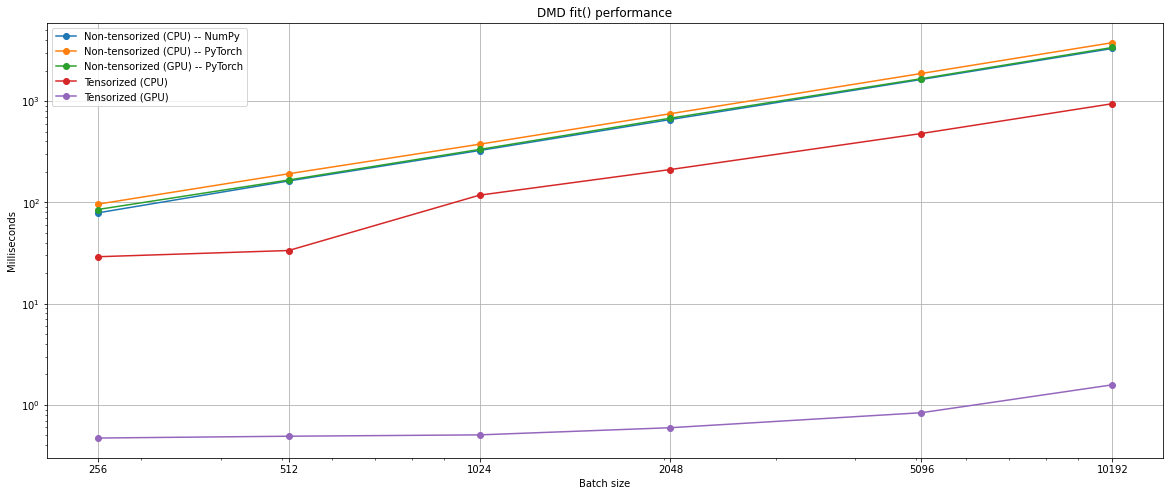

In [6]:
plt.figure(figsize=(20,8))

plt.title('DMD fit() performance')

plt.loglog(mininbatch_size, nontensorized_cpu_numpy, '-o', label='Non-tensorized (CPU) -- NumPy')
plt.loglog(mininbatch_size, nontensorized_cpu, '-o', label='Non-tensorized (CPU) -- PyTorch')
plt.loglog(mininbatch_size, nontensorized_gpu, '-o', label='Non-tensorized (GPU) -- PyTorch')
plt.loglog(mininbatch_size, tensorized_cpu, '-o', label='Tensorized (CPU)')
plt.loglog(mininbatch_size, tensorized_gpu, '-o', label='Tensorized (GPU)')

plt.xticks(mininbatch_size, mininbatch_size)
plt.xlabel('Batch size')
plt.ylabel('Milliseconds')

plt.grid()
plt.legend()

plt.show()

The GPU version wins by orders of magnitude, even at small batch sizes.

## SVD drivers
+ `gesvd` is chosen by default
+ `gesvdj` not applicable because we don't have symmetric matrices
+ `gesvda` (approximate) does not work because some entries become `nan` for some reason

## References
+ https://developer.download.nvidia.com/video/gputechconf/gtc/2019/presentation/s9226-fast-singular-value-decomposition-on-gpus-v2.pdf
+ https://pytorch.org/docs/stable/generated/torch.linalg.svd.html
+ https://github.com/pytorch/pytorch/issues/41306